# I. Data Retrieval (SQLite)

In [1]:
import sqlite3
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy import stats
import numpy as np
import pickle
import glob
from sklearn.preprocessing import LabelEncoder
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])
conn.close()


Tables in the database:
sites
sqlite_sequence
alexa_ranks
policy_texts
policy_htmls
policy_reader_view_htmls
policy_snapshots


In [3]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()

cursor.execute("SELECT COUNT(*) FROM policy_texts")
policy_texts_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM sites")
sites_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM policy_snapshots")
snapshots_count = cursor.fetchone()[0]

conn.close()

print(f"policy_texts rows: {policy_texts_count}")
print(f"sites rows: {sites_count}")
print(f"policy_snapshots rows: {snapshots_count}")

policy_texts rows: 333986
sites rows: 130620
policy_snapshots rows: 1071487


In [4]:
def load_combined_data(chunksize=50000):
    conn = sqlite3.connect('/app/Data/release_db.sqlite')
    
    query = """
    SELECT 
        s.domain,
        s.categories,
        pt.flesch_kincaid,
        pt.smog,
        pt.flesch_ease,
        pt.length,
        ps.year,
        ps.phase,
        ar.rank as alexa_rank
    FROM 
        sites s
    JOIN 
        policy_snapshots ps ON s.id = ps.site_id
    JOIN 
        policy_texts pt ON ps.policy_text_id = pt.id
    LEFT JOIN
        alexa_ranks ar ON s.id = ar.site_id AND ps.year = ar.year
    """
    
    chunks = []
    for chunk in pd.read_sql_query(query, conn, chunksize=chunksize):
        print(f"Loaded chunk of size: {len(chunk)}")
        chunks.append(chunk)
        
    conn.close()
    
    return pd.concat(chunks, ignore_index=True)

# Load the combined data
df = load_combined_data()
print(f"Total rows loaded: {len(df)}")


Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 20814
Total rows loaded: 1

In [5]:
df.head()

,domain,categories,flesch_kincaid,smog,flesch_ease,length,year,phase,alexa_rank
0,docusign.com,business;informationtech,14.938384,18.351184,difficult,14137,2003,B,NaN
1,docusign.com,business;informationtech,13.762202,18.171460,difficult,14366,2004,B,NaN
2,docusign.com,business;informationtech,13.640407,18.062587,difficult,14363,2006,B,NaN
3,docusign.com,business;informationtech,13.640407,18.062587,difficult,14363,2006,A,NaN
4,docusign.com,business;informationtech,13.762202,18.171460,difficult,14366,2004,A,NaN


In [6]:
df.columns


Index(['domain', 'categories', 'flesch_kincaid', 'smog', 'flesch_ease',
       'length', 'year', 'phase', 'alexa_rank'],
      dtype='object')

In [7]:
nan_counts = df.isna().sum()
print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
domain                 0
categories             0
flesch_kincaid     42650
smog              617166
flesch_ease        42650
length                 0
year                   0
phase                  0
alexa_rank        327817
dtype: int64


# II. Exploratory Analyses

## 1. Correlation Matrix: Readability Scores

In [8]:
correlation_matrix = df[['flesch_kincaid', 'smog']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                flesch_kincaid      smog
flesch_kincaid        1.000000  0.876019
smog                  0.876019  1.000000


In [9]:
correlation_matrix

,flesch_kincaid,smog
flesch_kincaid,1.000000,0.876019
smog,0.876019,1.000000


## 2. Flesch-Kincaid Score Distribution 

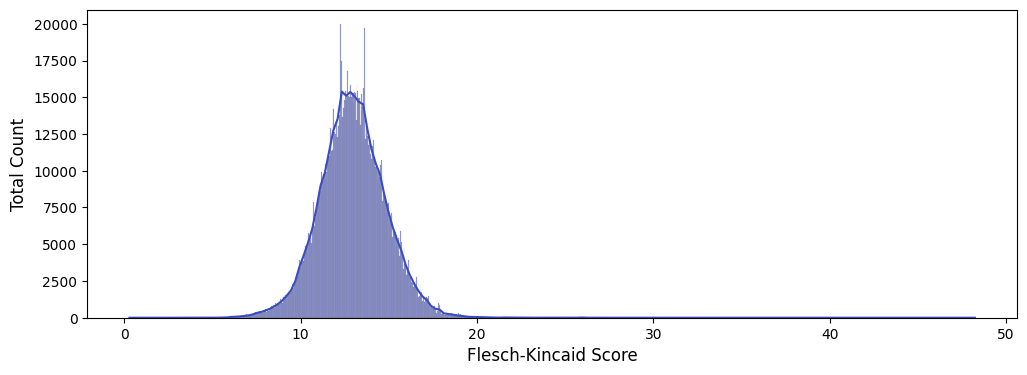

In [10]:
plt.figure(figsize=(12, 4))
sns.histplot(df['flesch_kincaid'], kde=True, color='#3B4CC0') 
plt.xlabel('Flesch-Kincaid Score', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.savefig("FK_dist.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
mode = df['flesch_kincaid'].mode().values[0]
print(f"Statistical mode: {mode}")


Statistical mode: 13.634165335463262


## 3. SMOG Score Distribution 

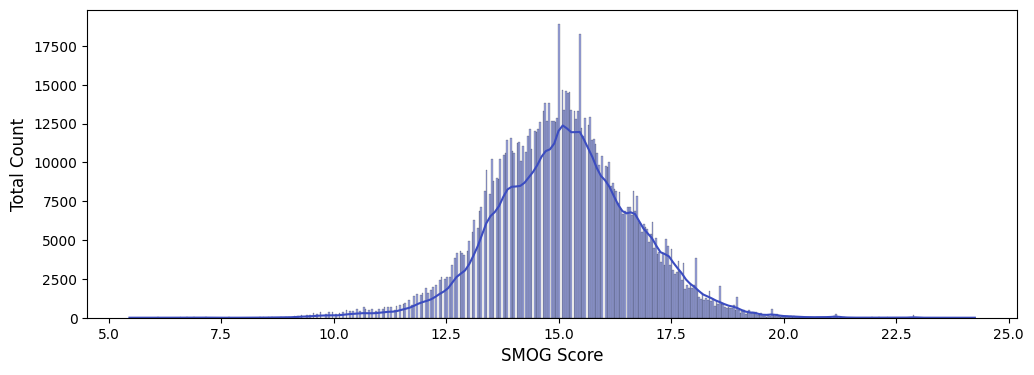

In [12]:
plt.figure(figsize=(12, 4))
sns.histplot(df['smog'], kde=True, color='#3B4CC0') 
plt.xlabel('SMOG Score', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.savefig("smog_dist.png", dpi=300, bbox_inches='tight')
plt.show()

## 4. Flesch-Ease Distribution 

In [13]:
categories = df['flesch_ease'].value_counts().sort_index()
print("Categories and their counts:")
print(categories)

Categories and their counts:
difficult           1353924
easy                     17
fairly_difficult     142760
fairly_easy             405
standard              10440
very_confusing       170606
very_easy                12
Name: flesch_ease, dtype: int64


/tmp/ipykernel_147820/287890983.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


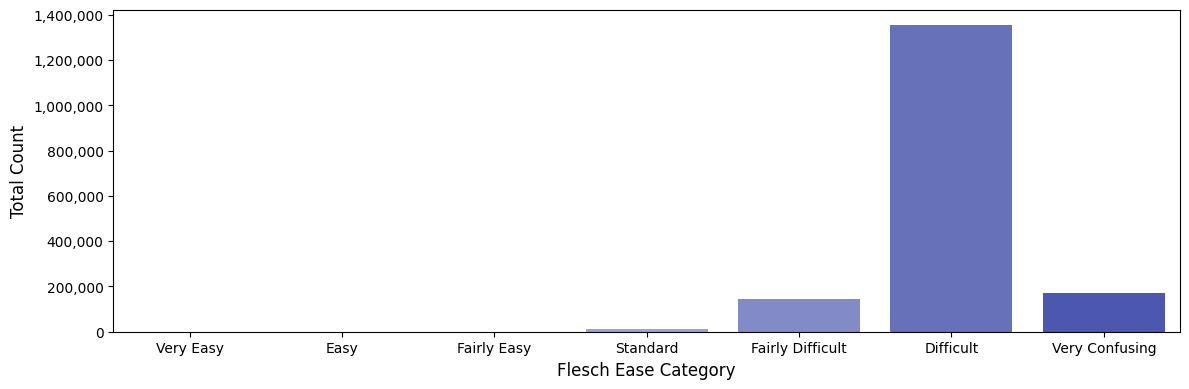

In [14]:
custom_palette = sns.light_palette("#3B4CC0", n_colors=7, reverse=False)

category_order = [
    'very_easy', 'easy', 'fairly_easy', 'standard', 'fairly_difficult', 'difficult', 'very_confusing'
]

plt.figure(figsize=(12, 4))
ax = sns.countplot(
    data=df,
    x='flesch_ease',
    order=category_order,
    palette=custom_palette
)

plt.xticks(range(len(category_order)), [c.replace('_', ' ').title() for c in category_order], fontsize=10)

plt.xlabel('Flesch Ease Category', fontsize=12)
plt.ylabel('Total Count', fontsize=12)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.savefig("FE_dist.png", dpi=300, bbox_inches='tight')
plt.show()

## 5. Policy Length Distribution 

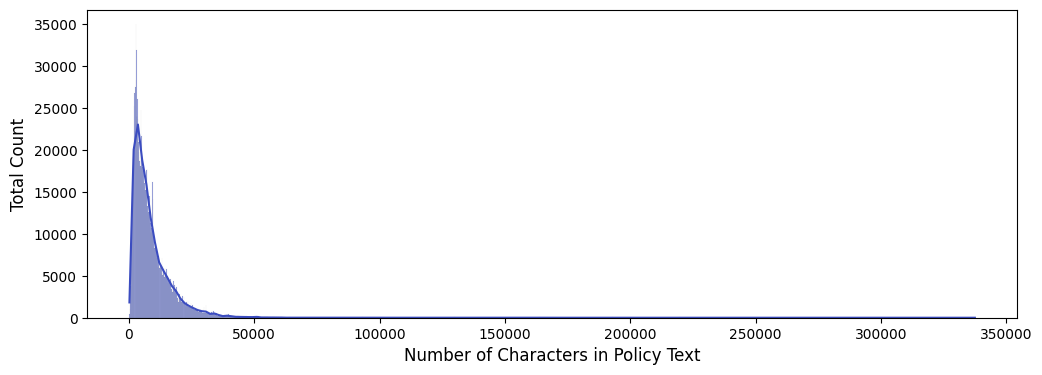

In [15]:
plt.figure(figsize=(12, 4))
sns.histplot(df['length'], kde=True, color='#3B4CC0') 
plt.xlabel('Number of Characters in Policy Text', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.savefig("length_dist.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
min_length = df['length'].min()
print(f"Minimum policy length: {min_length}")

Minimum policy length: 185


In [17]:
median_length = df['length'].median()
print(f"Median policy length: {median_length}")


Median policy length: 6565.0


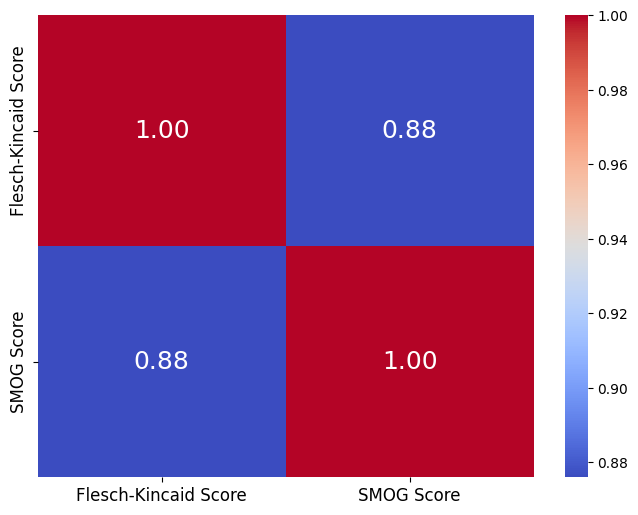

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 18}, cbar=True)
plt.xticks(ticks=[0.5, 1.5], labels=["Flesch-Kincaid Score", "SMOG Score"], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=["Flesch-Kincaid Score", "SMOG Score"], fontsize=12)
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# III. How has policy comprehension changed over time? (FK, FE, SMOG, Length)

## 1. FK, SMOG

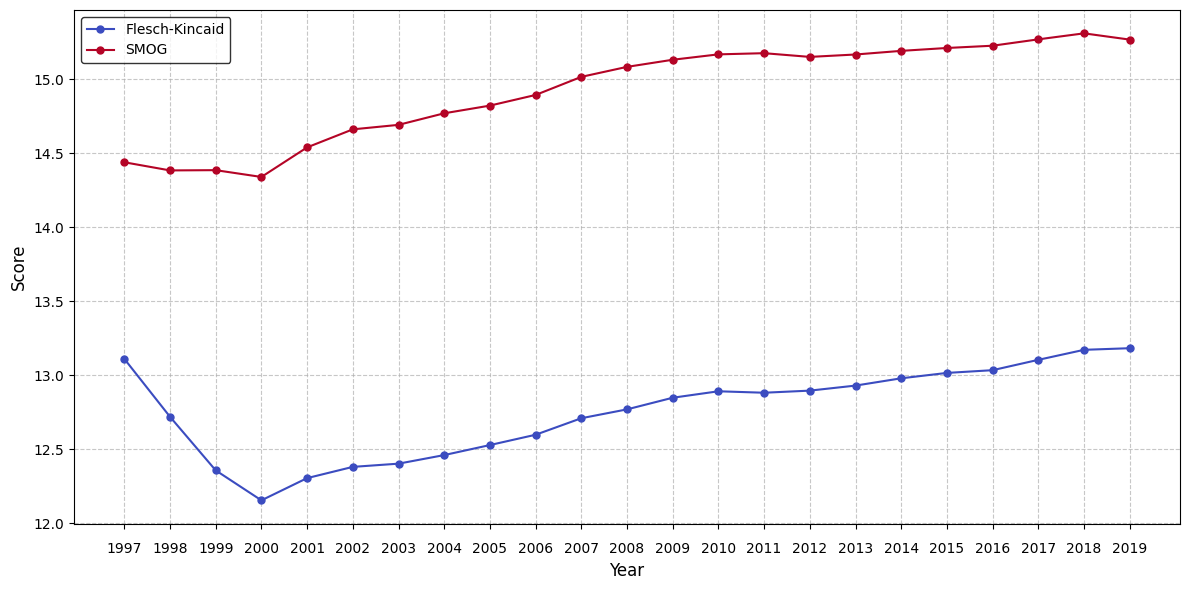

In [19]:
yearly_averages = df.groupby('year')[['flesch_kincaid', 'smog']].mean()

plt.figure(figsize=(12, 6))
plt.plot(
    yearly_averages.index, 
    yearly_averages['flesch_kincaid'], 
    marker='o', 
    markersize=5,  
    color='#3B4CC0',  
    label='Flesch-Kincaid'
)
plt.plot(
    yearly_averages.index, 
    yearly_averages['smog'], 
    marker='o',  
    markersize=5,  
    color='#B40426',  
    label='SMOG'
)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(yearly_averages.index, fontsize=10)  
plt.gca().tick_params(axis='x', pad=10)  

plt.legend(fontsize=10, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("readability_time.png", dpi=300, bbox_inches='tight')
plt.show()


In [20]:
yearly_averages_reset = yearly_averages.reset_index()

def analyze_yearly_trend(score_type):
    X = sm.add_constant(yearly_averages_reset['year'])
    y = yearly_averages_reset[score_type]
    
    model = sm.OLS(y, X).fit()
    
    print(f"\nRegression Results for {score_type} (Using Yearly Averages):")
    print(model.summary())
    
    correlation = yearly_averages_reset[['year', score_type]].corr().iloc[0,1]
    print(f"Correlation coefficient between year and {score_type}: {correlation:.4f}")

analyze_yearly_trend('flesch_kincaid')


Regression Results for flesch_kincaid (Using Yearly Averages):
                            OLS Regression Results                            
Dep. Variable:         flesch_kincaid   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     25.84
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           4.93e-05
Time:                        11:47:55   Log-Likelihood:                 4.4094
No. Observations:                  23   AIC:                            -4.819
Df Residuals:                      21   BIC:                            -2.548
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [21]:
analyze_yearly_trend('smog')


Regression Results for smog (Using Yearly Averages):
                            OLS Regression Results                            
Dep. Variable:                   smog   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     199.0
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           3.50e-12
Time:                        11:47:55   Log-Likelihood:                 20.334
No. Observations:                  23   AIC:                            -36.67
Df Residuals:                      21   BIC:                            -34.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------


Regression Results for flesch_kincaid (Using Yearly Averages):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -54.3159     13.196     -4.116      0.000     -81.758     -26.874
year           0.0334      0.007      5.083      0.000       0.020       0.047

Regression Results for smog (Using Yearly Averages):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -78.2105      6.603    -11.845      0.000     -91.942     -64.479
year           0.0464      0.003     14.105      0.000       0.040       0.053


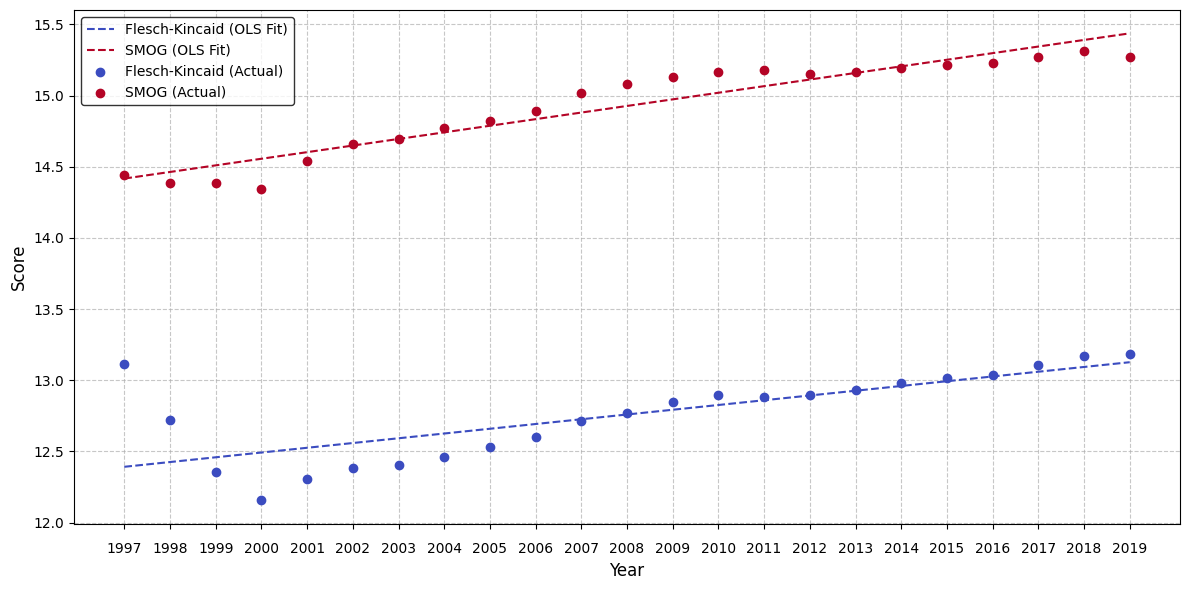

In [22]:
yearly_averages_reset = yearly_averages.reset_index()

def get_ols_fit(score_type):
    X = sm.add_constant(yearly_averages_reset['year'])  
    y = yearly_averages_reset[score_type]
    model = sm.OLS(y, X).fit()  
    print(f"\nRegression Results for {score_type} (Using Yearly Averages):")
    print(model.summary().tables[1]) 
    return model.predict(X)  

flesch_kincaid_fit = get_ols_fit('flesch_kincaid')
smog_fit = get_ols_fit('smog')

plt.figure(figsize=(12, 6))

plt.plot(
    yearly_averages_reset['year'], 
    flesch_kincaid_fit, 
    color='#3B4CC0', 
    linestyle='--', 
    label='Flesch-Kincaid (OLS Fit)'
)

plt.plot(
    yearly_averages_reset['year'], 
    smog_fit, 
    color='#B40426', 
    linestyle='--', 
    label='SMOG (OLS Fit)'
)

plt.scatter(
    yearly_averages_reset['year'], 
    yearly_averages_reset['flesch_kincaid'], 
    color='#3B4CC0', 
    label='Flesch-Kincaid (Actual)', 
    zorder=3
)
plt.scatter(
    yearly_averages_reset['year'], 
    yearly_averages_reset['smog'], 
    color='#B40426', 
    label='SMOG (Actual)', 
    zorder=3
)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(yearly_averages_reset['year'], fontsize=10)
plt.gca().tick_params(axis='x', pad=10)
plt.legend(fontsize=10, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()


plt.savefig("readability_time_with_ols.png", dpi=300, bbox_inches='tight')
plt.show()


## 2. Flesch-Ease

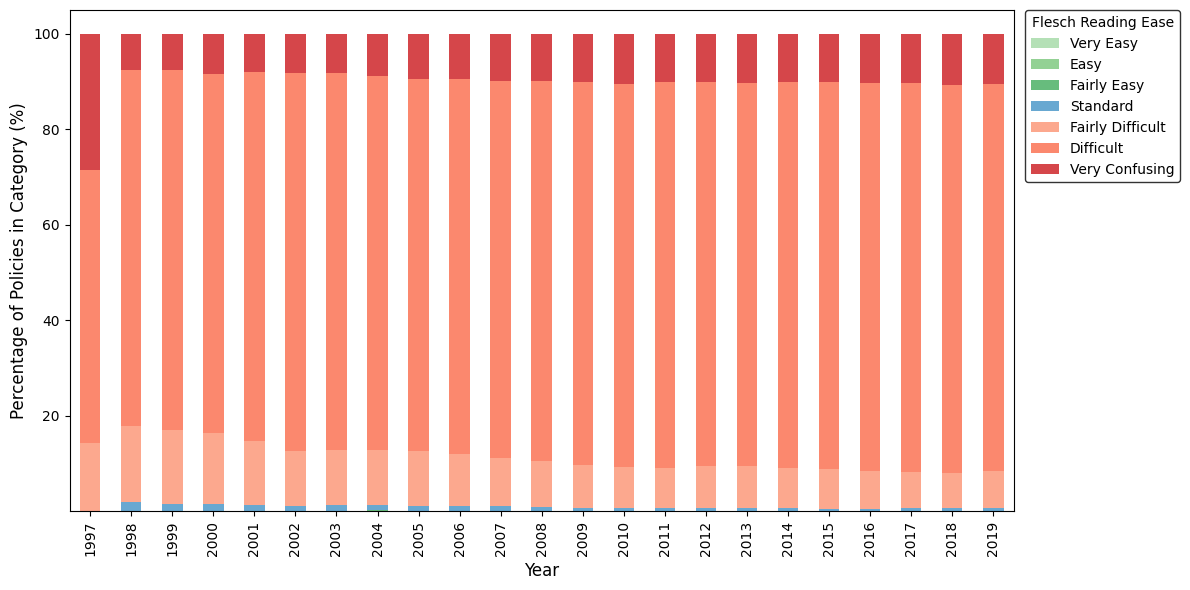

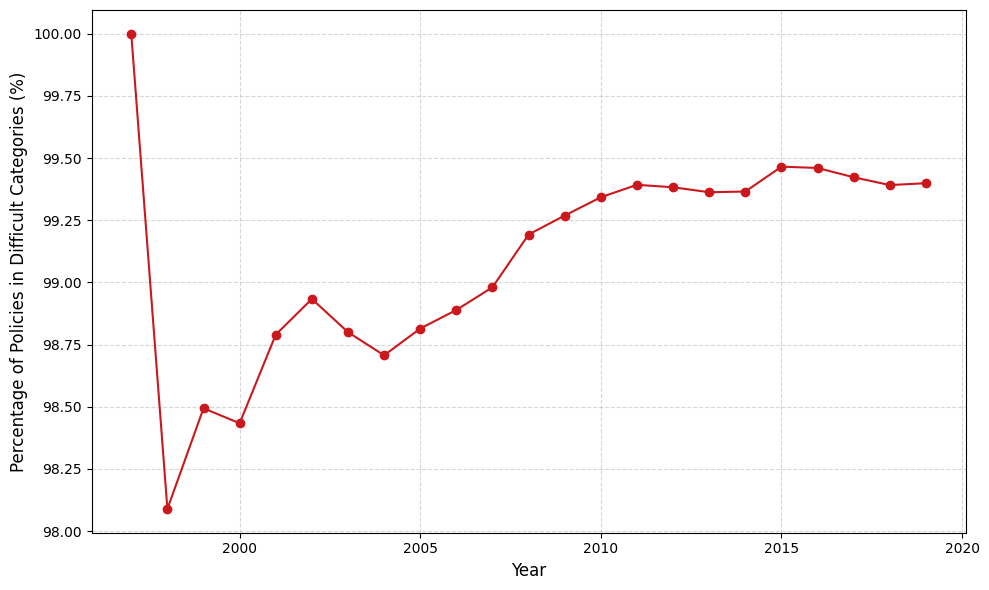

In [23]:
flesch_ease_percentages = df.groupby(['year', 'flesch_ease']).size().unstack(fill_value=0)
flesch_ease_percentages = flesch_ease_percentages.div(flesch_ease_percentages.sum(axis=1), axis=0) * 100

flesch_ease_percentages = flesch_ease_percentages.rename(
    columns=lambda x: x.replace('_', ' ').title()
)

category_order = ['Very Easy', 'Easy', 'Fairly Easy', 'Standard', 
                  'Fairly Difficult', 'Difficult', 'Very Confusing']
flesch_ease_percentages = flesch_ease_percentages[category_order]

colors = {
    'Very Easy': '#A2D9A4',  # Light green
    'Easy': '#78C679',       # Medium green
    'Fairly Easy': '#41AB5D',# Dark green
    'Standard': '#4292C6',   # Blue
    'Fairly Difficult': '#FC9272',  # Light red
    'Difficult': '#FB6A4A',         # Medium red
    'Very Confusing': '#CB181D'     # Dark red
}

flesch_ease_percentages.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    alpha=0.8,
    color=[colors[category] for category in category_order]
)

plt.xlabel('Year', size=12)
plt.ylabel('Percentage of Policies in Category (%)', size=12)
plt.legend(title='Flesch Reading Ease', bbox_to_anchor=(1.005, 1.013), loc='upper left', edgecolor='black')
plt.tight_layout()
plt.savefig("ease_time.png", dpi=300, bbox_inches='tight')
plt.show()

difficult_categories = ['Fairly Difficult', 'Difficult', 'Very Confusing']
difficult_percentages = flesch_ease_percentages[difficult_categories].sum(axis=1)

plt.figure(figsize=(10, 6))
difficult_percentages.plot(kind='line', marker='o', color='#CB181D')
plt.xlabel('Year', size=12)
plt.ylabel('Percentage of Policies in Difficult Categories (%)', size=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.savefig("difficult_ease_time.png", dpi=300, bbox_inches='tight')
plt.show()


In [24]:
def analyze_flesch_ease_trend():
    yearly_mode = df.groupby('year')['flesch_ease'].agg(lambda x: x.value_counts().index[0])
    
    print("\nMost common Flesch Reading Ease category by year:")
    print(yearly_mode)
    
    yearly_percentages = df.groupby('year')['flesch_ease'].value_counts(normalize=True).unstack()
    
    print("\nPercentage of each Flesch Reading Ease category by year:")
    print(yearly_percentages)
    
    contingency_table = pd.crosstab(df['year'], df['flesch_ease'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\nChi-square test for independence between year and Flesch Reading Ease category:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")    

analyze_flesch_ease_trend()



Most common Flesch Reading Ease category by year:
year
1997    difficult
1998    difficult
1999    difficult
2000    difficult
2001    difficult
2002    difficult
2003    difficult
2004    difficult
2005    difficult
2006    difficult
2007    difficult
2008    difficult
2009    difficult
2010    difficult
2011    difficult
2012    difficult
2013    difficult
2014    difficult
2015    difficult
2016    difficult
2017    difficult
2018    difficult
2019    difficult
Name: flesch_ease, dtype: object

Percentage of each Flesch Reading Ease category by year:
flesch_ease  difficult      easy  fairly_difficult  fairly_easy  standard  \
year                                                                        
1997          0.571429       NaN          0.142857          NaN       NaN   
1998          0.745223       NaN          0.159236          NaN  0.019108   
1999          0.754518       NaN          0.155120          NaN  0.015060   
2000          0.751526       NaN          0.149190    

# IV. How does policy comprehension relate to website popularity? (FK, SMOG, Length)

## 1. FK vs. Log Alexa Rank

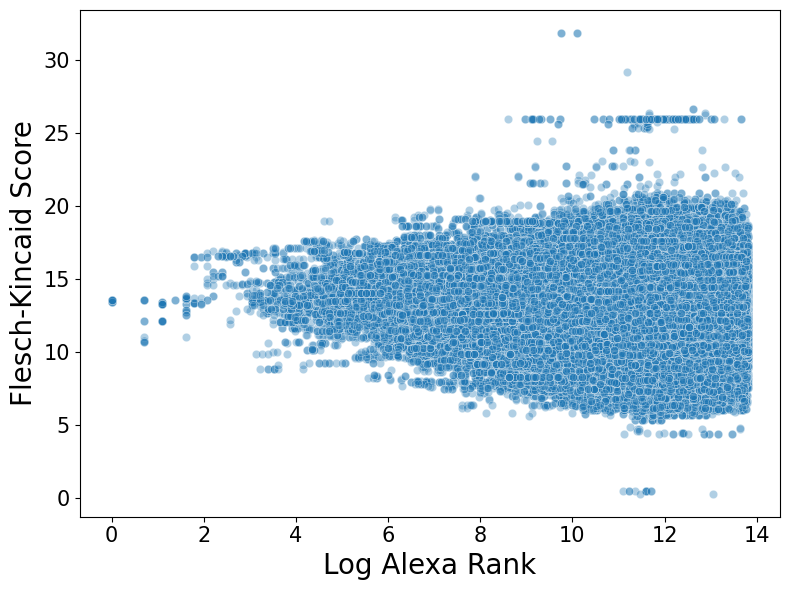

In [25]:
df['log_alexa_rank'] = np.log(df['alexa_rank'])

df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_alexa_rank', 'flesch_kincaid', 'smog'])

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='log_alexa_rank', 
    y='flesch_kincaid', 
    data=df_clean, 
    alpha=0.35
)
plt.xlabel('Log Alexa Rank', fontsize=20)
plt.ylabel('Flesch-Kincaid Score', fontsize=20)
plt.xticks(fontsize=15)  
plt.yticks(fontsize=15) 
plt.tight_layout()
plt.savefig("log_alexa_vs_flesch_kincaid.png", dpi=300, bbox_inches='tight')
plt.show()


In [26]:
print("Number of NaN values in each column before cleaning:")
print(df[['log_alexa_rank', 'flesch_kincaid', 'smog']].isna().sum())

print("\nShape of dataframe:")
print(f"Original: {df.shape}")
print(f"After cleaning: {df_clean.shape}")

Number of NaN values in each column before cleaning:
log_alexa_rank    327817
flesch_kincaid     42650
smog              617166
dtype: int64

Shape of dataframe:
Original: (1720814, 10)
After cleaning: (909552, 10)


In [27]:
X_fk = sm.add_constant(df_clean['log_alexa_rank'])
y_fk = df_clean['flesch_kincaid']

X_smog = sm.add_constant(df_clean['log_alexa_rank'])
y_smog = df_clean['smog']

model_fk = sm.OLS(y_fk, X_fk).fit()
model_smog = sm.OLS(y_smog, X_smog).fit()

print("Regression Results for Flesch-Kincaid:")
print(model_fk.summary())

Regression Results for Flesch-Kincaid:
                            OLS Regression Results                            
Dep. Variable:         flesch_kincaid   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3767.
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:48:17   Log-Likelihood:            -1.8229e+06
No. Observations:              909552   AIC:                         3.646e+06
Df Residuals:                  909550   BIC:                         3.646e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const

## 2. SMOG vs. Log Alexa Rank

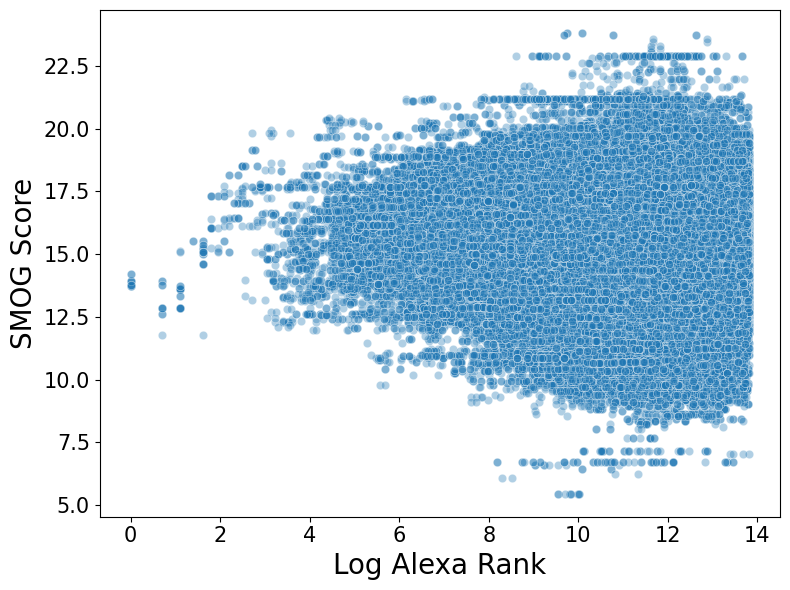

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='log_alexa_rank', 
    y='smog', 
    data=df_clean, 
    alpha=0.35,  
)
plt.xlabel('Log Alexa Rank', fontsize=20)
plt.ylabel('SMOG Score', fontsize=20)
plt.xticks(fontsize=15)  
plt.yticks(fontsize=15) 
plt.tight_layout()
plt.savefig("log_alexa_vs_smog.png", dpi=300, bbox_inches='tight')
plt.show()

We use the logarithm of Alexa rank for several reasons:

* Alexa ranks follow a highly skewed distribution - the difference in visibility between rank 1 and 100 is much larger than between rank 10,000 and 10,1002
* Taking the logarithm helps normalize this skewed distribution, making the relationship between website popularity and readability scores easier to visualize and analyze2
* The log transformation is particularly useful when dealing with rankings that span several orders of magnitude, as is the case with Alexa ranks which range from 1 to over 100,0002

In [29]:
print("\nRegression Results for SMOG:")
print(model_smog.summary())


Regression Results for SMOG:
                            OLS Regression Results                            
Dep. Variable:                   smog   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2285.
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:48:33   Log-Likelihood:            -1.6997e+06
No. Observations:              909552   AIC:                         3.400e+06
Df Residuals:                  909550   BIC:                         3.400e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

FK: The negative coefficient for log_alexa_rank (-0.0809) indicates that as Alexa rank increases (meaning less popular websites), the FK score decreases (more readable). This relationship is statistically significant (p < 0.001) with a narrow confidence interval [-0.083, -0.078].

SMOG: Similarly, the negative coefficient for log_alexa_rank (-0.0550) shows the same directional relationship with SMOG scores. The relationship is also statistically significant (p < 0.001) with a narrow confidence interval [-0.057, -0.053]. The effect is slightly smaller than with FK.


## 3. Policy Length vs. Log Alexa Rank

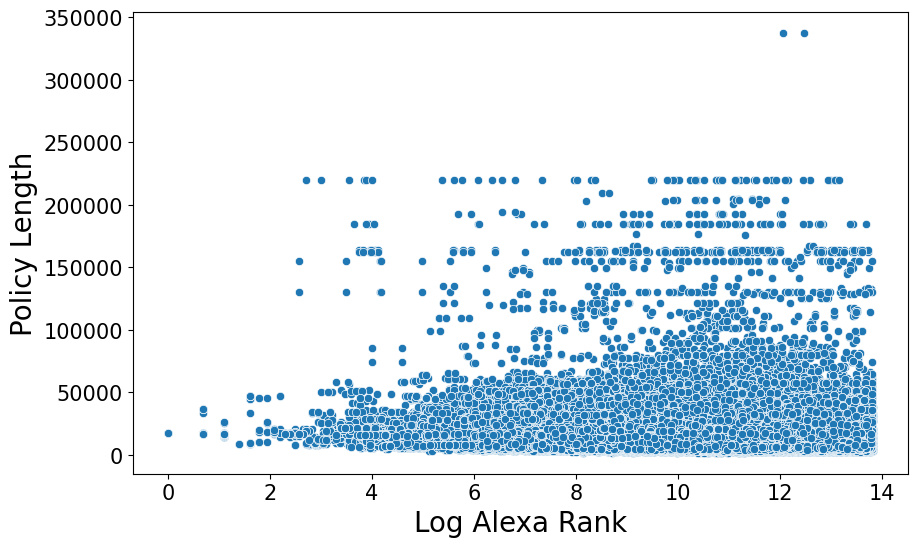

Regression Results for Policy Length:
                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                 1.884e+04
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:48:42   Log-Likelihood:            -9.5612e+06
No. Observations:              909552   AIC:                         1.912e+07
Df Residuals:                  909550   BIC:                         1.912e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const 

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_alexa_rank', y='length', data=df_clean)
# plt.title('Log Alexa Rank vs Policy Length')
plt.xlabel('Log Alexa Rank', fontsize=20)
plt.ylabel('Policy Length', fontsize=20)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.savefig("log_alexa_vs_length.png", dpi=300, bbox_inches='tight')
plt.show()

X = sm.add_constant(df_clean['log_alexa_rank'])
y = df_clean['length']

model = sm.OLS(y, X).fit()

print("Regression Results for Policy Length:")
print(model.summary())

# V. How does policy comprehension change across industry type (high data collection vs. low)?

In [31]:
all_categories = df['categories'].str.split(';', expand=True).stack().unique()
print("All unique individual categories:")
print(all_categories)

All unique individual categories:
['business' 'informationtech' 'education' 'searchenginesandportals'
 'uncategorized' 'vehicles' 'shopping' 'foodandrecipes' '' 'parked'
 'entertainment' 'adult' 'sports' 'games' 'newsandmedia' 'travel'
 'jobrelated' 'economyandfinance' 'streamingmedia' 'realestate'
 'blogsandpersonal' 'contentserver' 'gambling' 'personals' 'advertising'
 'messageboardsandforums' 'weapons' 'health' 'religion' 'mediasharing'
 'drugs' 'proxyandfilteravoidance' 'illegalcontent' 'socialnetworking'
 'humor' 'alcoholandtobacco' 'chatandmessaging' 'translators' 'deceptive'
 'hacking' 'malicious' 'virtualreality']


In [32]:
# Split the categories column
df['categories'] = df['categories'].fillna('')
categories = df['categories'].str.get_dummies(sep=';')


df_expanded = pd.concat([df, categories], axis=1)
df_expanded.head()

,domain,categories,flesch_kincaid,smog,flesch_ease,length,year,phase,alexa_rank,log_alexa_rank,...,shopping,socialnetworking,sports,streamingmedia,translators,travel,uncategorized,vehicles,virtualreality,weapons
0,docusign.com,business;informationtech,14.938384,18.351184,difficult,14137,2003,B,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,docusign.com,business;informationtech,13.762202,18.171460,difficult,14366,2004,B,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,docusign.com,business;informationtech,13.640407,18.062587,difficult,14363,2006,B,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,docusign.com,business;informationtech,13.640407,18.062587,difficult,14363,2006,A,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,docusign.com,business;informationtech,13.762202,18.171460,difficult,14366,2004,A,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_expanded.columns

Index(['domain', 'categories', 'flesch_kincaid', 'smog', 'flesch_ease',
       'length', 'year', 'phase', 'alexa_rank', 'log_alexa_rank', 'adult',
       'advertising', 'alcoholandtobacco', 'blogsandpersonal', 'business',
       'chatandmessaging', 'contentserver', 'deceptive', 'drugs',
       'economyandfinance', 'education', 'entertainment', 'foodandrecipes',
       'gambling', 'games', 'hacking', 'health', 'humor', 'illegalcontent',
       'informationtech', 'jobrelated', 'malicious', 'mediasharing',
       'messageboardsandforums', 'newsandmedia', 'parked', 'personals',
       'proxyandfilteravoidance', 'realestate', 'religion',
       'searchenginesandportals', 'shopping', 'socialnetworking', 'sports',
       'streamingmedia', 'translators', 'travel', 'uncategorized', 'vehicles',
       'virtualreality', 'weapons'],
      dtype='object')

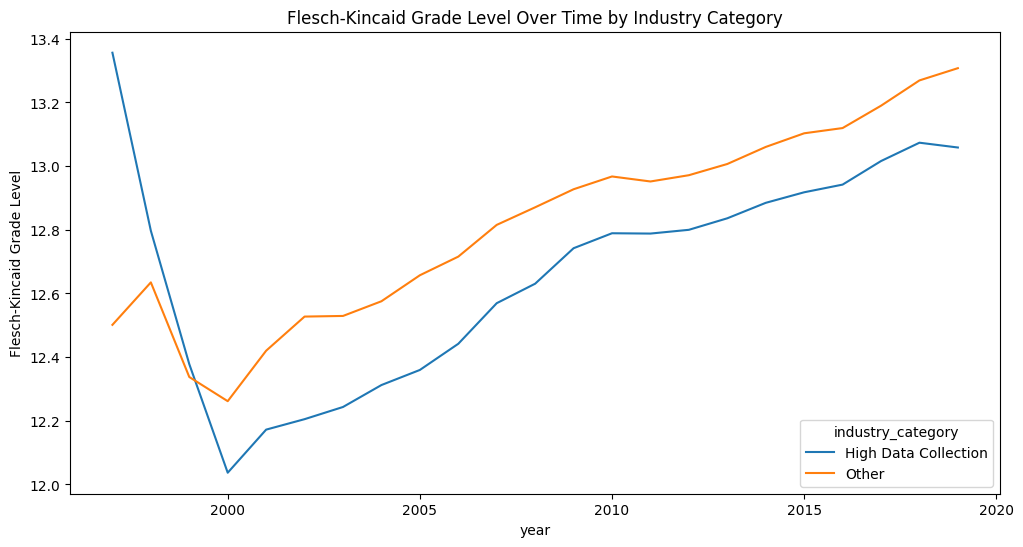

In [34]:
high_data_industries = ['advertising', 'socialnetworking', 'chatandmessaging', 'newsandmedia', 
                        'games', 'entertainment', 'informationtech', 'shopping', 
                        'mediasharing', 'searchenginesandportals', 'personals']

def categorize_industry(row):
    if any(row[industry] == 1 for industry in high_data_industries):
        return 'High Data Collection'
    return 'Other'

df_expanded['industry_category'] = df_expanded.apply(categorize_industry, axis=1)

yearly_readability = df_expanded.groupby(['year', 'industry_category'])[['flesch_kincaid', 'smog']].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_readability, x='year', y='flesch_kincaid', hue='industry_category')
plt.title('Flesch-Kincaid Grade Level Over Time by Industry Category')
plt.ylabel('Flesch-Kincaid Grade Level')
plt.show()


Number of data points in each category per year:
industry_category  High Data Collection  Other
year                                          
1997                                  5      4
1998                                 86     79
1999                                361    354
2000                               1813   2085
2001                               3036   3611
2002                               4426   5452
2003                               5536   7117
2004                               6920   9155
2005                               8069  10787
2006                              11076  14962
2007                              13526  18380
2008                              15839  22167
2009                              31531  43203
2010                              42426  58672
2011                              54549  74869
2012                              66479  87386
2013                              73790  93188
2014                              79159  95283
2015       

<Figure size 1200x600 with 0 Axes>

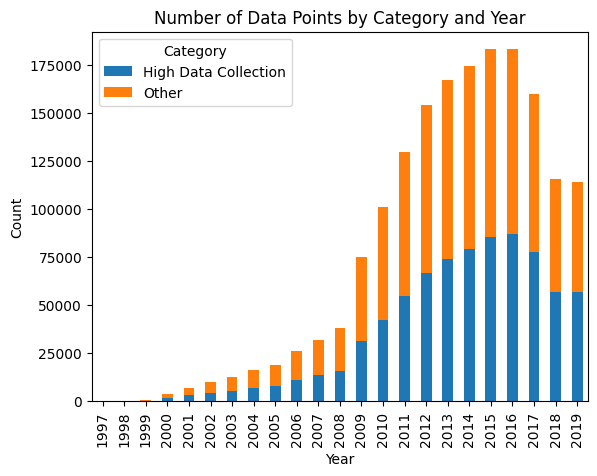

In [35]:
# Count the number of data points in each category per year
category_counts = df_expanded.groupby(['year', 'industry_category']).size().unstack(fill_value=0)

print("Number of data points in each category per year:")
print(category_counts)

# Calculate the total number of data points in each category
total_counts = category_counts.sum()
print("\nTotal number of data points in each category:")
print(total_counts)

plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', stacked=True)
plt.title('Number of Data Points by Category and Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Category')
plt.savefig("category_counts_by_year.png", dpi=300, bbox_inches='tight')
plt.show()


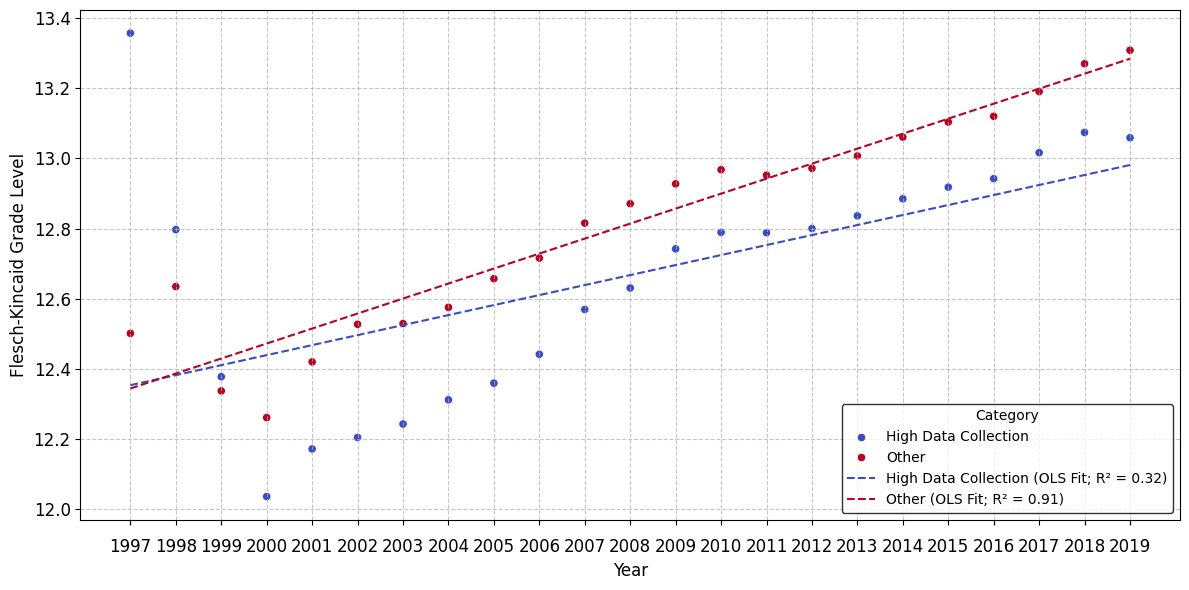

In [36]:
plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=yearly_readability,
    x='year',
    y='flesch_kincaid',
    hue='industry_category',
    style='industry_category',
    markers=['o', 'o'], 
    palette={'High Data Collection': '#3B4CC0', 'Other': '#B40426'}
)

for category in yearly_readability['industry_category'].unique():
    category_data = yearly_readability[yearly_readability['industry_category'] == category]
    slope, intercept, r_value, p_value, std_err = stats.linregress(category_data['year'], category_data['flesch_kincaid'])
    line = slope * category_data['year'] + intercept
    plt.plot(
        category_data['year'],
        line,
        linestyle='--',
        label=f'{category} (OLS Fit; R² = {r_value**2:.2f})',
        color='#3B4CC0' if category == 'High Data Collection' else '#B40426'
    )

plt.xticks(ticks=range(yearly_readability['year'].min(), yearly_readability['year'].max() + 1), fontsize=12)

plt.ylabel('Flesch-Kincaid Grade Level', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.yticks(fontsize=12)
plt.gca().tick_params(axis='x', pad=10)

legend = plt.legend(title='Category', fontsize=10)
legend.get_frame().set_edgecolor('black')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig("read_high_data.png", dpi=300, bbox_inches="tight")
plt.show()


In [37]:
high_data_collection = yearly_readability[yearly_readability['industry_category'] == 'High Data Collection']
X_high = sm.add_constant(high_data_collection['year'])
y_high = high_data_collection['flesch_kincaid']
model_high = sm.OLS(y_high, X_high).fit()

print("Regression Results for High Data Collection:")
print(model_high.summary())

Regression Results for High Data Collection:
                            OLS Regression Results                            
Dep. Variable:         flesch_kincaid   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     9.706
Date:                Wed, 08 Jan 2025   Prob (F-statistic):            0.00523
Time:                        11:49:58   Log-Likelihood:                -3.1979
No. Observations:                  23   AIC:                             10.40
Df Residuals:                      21   BIC:                             12.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

In [38]:
other_category = yearly_readability[yearly_readability['industry_category'] == 'Other']
X_other = sm.add_constant(other_category['year'])
y_other = other_category['flesch_kincaid']
model_other = sm.OLS(y_other, X_other).fit()

print("Regression Results for Other Category:")
print(model_other.summary())

Regression Results for Other Category:
                            OLS Regression Results                            
Dep. Variable:         flesch_kincaid   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     217.5
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           1.49e-12
Time:                        11:49:58   Log-Likelihood:                 23.267
No. Observations:                  23   AIC:                            -42.53
Df Residuals:                      21   BIC:                            -40.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        